In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function,division

import torch
import torchvision
import torchvision.transforms as tranys
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models,datasets
from torch.optim import lr_scheduler 
import time
import os
import copy


In [3]:
data_transforms = {
    'train': tranys.Compose([
        tranys.RandomResizedCrop(224),
        tranys.RandomHorizontalFlip(),
        tranys.ToTensor(),
        tranys.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': tranys.Compose([
        tranys.Resize(256),
        tranys.CenterCrop(224),
        tranys.ToTensor(),
        tranys.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}
master_f = '/home/omar/Desktop/pytorch/flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(master_f,x),
                                          data_transforms[x])
                 for x in ['train','val']}
data_loaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4
                                             ,shuffle=True, num_workers=4) 
                 for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

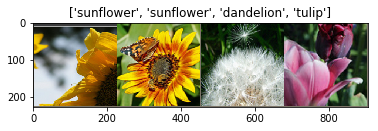

In [4]:
def imshow(img, title=None):
    img=img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std+mean
    img = np.clip(img, 0 ,1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(data_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
        

In [5]:
def train_model(model, criterion, optimizer, scheduler,num_epochs=4):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train','val']:
            if phase =='train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                    
            running_loss = 0.0 
            running_corrects= 0
            
            for inputs, labels in data_loaders[phase]:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss =  running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60 ))
    print('best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,5)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7 , gamma=0.1)

In [ ]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=2)

Epoch0/1
----------


In [ ]:
visualize_model(model_ft)